## Imports

In [1]:
import wandb
token="8e26c35ccfc23fee4b5a710c094eded4d52008d4"
wandb.login(key=token)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmed-elzayat02 (ahmed-elzayat02-cairo-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=a39ff3ec76ee511933e412cd8cfcd81be510f96404fd1fa8f2e0787f0415a38f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [53]:
from datasets import get_dataset_config_names
from datasets import load_dataset, concatenate_datasets
from collections import defaultdict, Counter
from datasets import DatasetDict
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.nn.functional import cross_entropy
from transformers import XLMRobertaConfig, AutoConfig, AutoTokenizer, DataCollatorForTokenClassification, Trainer, TrainingArguments, BertConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from huggingface_hub import notebook_login

## Data Preparation and Model Building

In [4]:
def get_data():    
    langs = ["de", "fr", "it", "en"]
    panx_ch = defaultdict(DatasetDict)
    
    for lang in langs:
        ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
        for split in ds: 
            panx_ch[lang][split] = ds[split].shuffle(seed=0)
        
    return panx_ch

panx_ch = get_data()

README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/837k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/932k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/459k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/464k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags.names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']


In [6]:
def create_tag_names(batch):
 return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}
    
panx_de = panx_ch["de"].map(create_tag_names)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [12]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient='index')

,LOC,ORG,PER
train,9778,8575,9290
validation,4968,4281,4569
test,4961,4157,4750


In [19]:
class BERTForTokenClassification(BertPreTrainedModel):
    """
    A token classification model based on BERT.

    This model is designed for token-level tasks such as Named Entity Recognition (NER). 
    It uses BERT as the backbone and adds a classification head on top for predicting 
    token labels.

    Attributes:
        config_class: The configuration class for XLM-Roberta.
        num_labels (int): Number of labels for the classification task.
        bert (BertModel): The Bert model without the pooling layer.
        dropout (nn.Dropout): Dropout layer for regularization.
        classifier (nn.Linear): A linear layer for mapping hidden states to label logits.

    Args:
        config (BertConfig): Configuration object containing the model's parameters.

    Methods:
        forward(input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
            Forward pass of the model.

            Args:
                input_ids (torch.Tensor): Tensor of input token IDs of shape `(batch_size, sequence_length)`.
                attention_mask (torch.Tensor, optional): Mask tensor of shape `(batch_size, sequence_length)` 
                                                         indicating which tokens to attend to.
                token_type_ids (torch.Tensor, optional): Tensor of shape `(batch_size, sequence_length)` 
                                                        specifying token types (not typically used in BERT models).
                labels (torch.Tensor, optional): Tensor of shape `(batch_size, sequence_length)` containing 
                                                 the true labels for each token.

            Returns:
                TokenClassifierOutput: An output object containing:
                    - `loss` (torch.Tensor, optional): The computed loss if `labels` are provided.
                    - `logits` (torch.Tensor): Logits of shape `(batch_size, sequence_length, num_labels)`.
                    - `hidden_states` (tuple, optional): Hidden states from the backbone model.
                    - `attentions` (tuple, optional): Attention weights from the backbone model.
    """
    
    config_class = BertConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids, **kwargs)
        
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        # Return model output object
        return TokenClassifierOutput(
            loss=loss, 
            logits=logits, 
            hidden_states=outputs.hidden_states, 
            attentions=outputs.attentions
        )

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
mbert_model_name = "bert-base-multilingual-cased"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_model_name)

mbert_config = AutoConfig.from_pretrained(mbert_model_name,
                num_labels=tags.num_classes,
                id2label=index2tag, label2id=tag2index)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
def tag_text(text, tags, model, tokenizer):
    """
    Tags a given text with predictions from a NER model.

    This function tokenizes the input text, runs it through a NER model, and 
    generates predictions for each token. The predictions are converted into 
    human-readable tag names, and the tokens and their corresponding tags are 
    returned as a pandas DataFrame.

    Args:
        text (str): The input text to be tagged.
        tags: A mapping or object containing tag names (e.g., `tags.names`).
        model: A pre-trained NER model that takes tokenized inputs and 
               outputs logits for each token.
        tokenizer: A tokenizer that splits the input text into tokens 
                   compatible with the model.
    
    Returns:
        pd.DataFrame: A DataFrame containing:
            - "Tokens": List of tokens from the input text.
            - "Tags": Predicted tags corresponding to each token.
    """
    tokens = tokenizer(text).tokens()
    input_ids = mbert_tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [26]:
def tokenize_and_align_labels(examples):
    """
    Tokenizes input sentences and aligns NER labels with tokenized outputs.

    This function uses a tokenizer that supports word-level tokenization and aligns 
    the NER tags to the subword tokenization scheme. It assigns `-100` to subword 
    tokens or special tokens to ensure they are ignored during the loss computation.

    Args:
        examples (dict): A dictionary containing:
            - "tokens" (list of list of str): Sentences represented as lists of tokens.
            - "ner_tags" (list of list of int): Corresponding NER tags for the tokens.

    Returns:
        dict: A dictionary containing:
            - Tokenized inputs (e.g., "input_ids", "attention_mask").
            - "labels": Aligned labels for the tokenized inputs.
    """
    tokenized_inputs = mbert_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [27]:
def encode_panx_dataset(corpus):
    """
    Encodes a PAN-X dataset by tokenizing the input sentences and aligning NER labels.

    This function applies the `tokenize_and_align_labels` function to the dataset using 
    batched processing, removing unnecessary columns (e.g., 'tokens', 'ner_tags', 'langs') 
    to prepare the dataset for model training.

    Args:
        corpus (DatasetDict): A `DatasetDict` object containing splits (e.g., 'train', 
                              'validation', 'test') with the features:
                              - "tokens": List of tokens for each sentence.
                              - "ner_tags": NER labels for the tokens.
                              - "langs": Language identifiers.

    Returns:
        DatasetDict: A `DatasetDict` with tokenized inputs and aligned labels, 
                     containing features such as "input_ids", "attention_mask", 
                     and "labels".
    """
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['tokens', 'ner_tags', 'langs'])

## Zero-shot Cross-lingual Transfer from English

In [28]:
panx_en_encoded = encode_panx_dataset(panx_ch["en"])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [29]:
def align_predictions(predictions, label_ids):
    """
    Aligns model predictions with their corresponding labels, excluding ignored indices.

    This function processes batched model predictions and label IDs, converting them 
    into human-readable tag names while skipping indices marked with `-100` (ignored labels). 
    It ensures that predictions and labels are aligned at the token level.

    Args:
        predictions (numpy.ndarray): Array of shape `(batch_size, seq_len, num_labels)` 
                                     containing the model's logits for each token.
        label_ids (numpy.ndarray): Array of shape `(batch_size, seq_len)` containing 
                                   the true label IDs for each token, with `-100` 
                                   indicating ignored tokens.

    Returns:
        tuple: A pair of lists:
            - preds_list (list of list of str): Predicted tags for each example in the batch.
            - labels_list (list of list of str): True tags for each example in the batch.
    """
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
                
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list

In [30]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_en_encoded["train"]) // batch_size
model_name = f"{mbert_model_name}-finetuned-panx-en"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [32]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred), "precision": precision_score(y_true, y_pred), "recall": recall_score(y_true, y_pred)}

In [34]:
data_collator = DataCollatorForTokenClassification(mbert_tokenizer)

In [35]:
def model_init():
    return (BERTForTokenClassification.from_pretrained(mbert_model_name, config=mbert_config).to(device))

In [37]:
notebook_login()

In [39]:
trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=panx_en_encoded["train"],
        eval_dataset=panx_en_encoded["validation"],
        tokenizer=mbert_tokenizer)

In [40]:
trainer.train() 

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.332600,0.249579,0.823382,0.811676,0.835431
2,0.192100,0.240583,0.839304,0.831587,0.847165
3,0.118700,0.243298,0.846501,0.838430,0.854729


TrainOutput(global_step=2502, training_loss=0.21430502700910484, metrics={'train_runtime': 345.7821, 'train_samples_per_second': 173.52, 'train_steps_per_second': 7.236, 'total_flos': 1049039580333888.0, 'train_loss': 0.21430502700910484, 'epoch': 3.0})

In [43]:
text_en = "Jeff Dean is a developer at Google in California"
tag_text(text_en, tags, trainer.model, mbert_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10
Tokens,[CLS],Jeff,Dean,is,a,developer,at,Google,in,California,[SEP]
Tags,O,B-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,O


In [44]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [45]:
f1_scores = defaultdict(dict)
f1_scores["en"]["en"] = get_f1_score(trainer, panx_en_encoded["test"])
print(f"F1-score of [en] model on [en] dataset: {f1_scores['en']['en']:.3f}")

F1-score of [en] model on [en] dataset: 0.845


In [46]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [47]:
f1_scores["en"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [en] model on [fr] dataset: {f1_scores['en']['fr']:.3f}")

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

F1-score of [en] model on [fr] dataset: 0.796


In [48]:
f1_scores["en"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [en] model on [it] dataset: {f1_scores['en']['it']:.3f}")

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

F1-score of [en] model on [it] dataset: 0.803


In [49]:
f1_scores["en"]["de"] = evaluate_lang_performance("de", trainer)
print(f"F1-score of [en] model on [de] dataset: {f1_scores['en']['de']:.3f}")

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

F1-score of [en] model on [de] dataset: 0.783


# Fine-Tuning on Multiple Languages at Once

In [65]:
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [66]:
corpora = []
for lang in ["de", "fr", "it", "en"]:
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    corpora.append(ds_encoded)

In [69]:
corpora_encoded = concatenate_splits(corpora)
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "mbert-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                 data_collator=data_collator, compute_metrics=compute_metrics,
                 tokenizer=mbert_tokenizer, train_dataset=corpora_encoded["train"],
                 eval_dataset=corpora_encoded["validation"])
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.213900,0.160881,0.876460,0.873045,0.879902
2,0.121500,0.149217,0.890623,0.884107,0.897236
3,0.070700,0.167362,0.899050,0.895450,0.902680


TrainOutput(global_step=10002, training_loss=0.1353268309089809, metrics={'train_runtime': 1389.8472, 'train_samples_per_second': 172.681, 'train_steps_per_second': 7.196, 'total_flos': 4419890662669440.0, 'train_loss': 0.1353268309089809, 'epoch': 3.0})

In [70]:
langs=["de", "fr", "it", "en"]
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
    
scores_data = {"en": f1_scores["en"], "all": f1_scores["all"]}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tuned on", columns="Evaluated on", inplace=True)
f1_scores_df

Evaluated on,en,fr,it,de
Fine-tuned on,,,,
en,0.8454,0.7961,0.8029,0.7832
all,0.8507,0.9132,0.9263,0.8982


In [83]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 8),
    labels.view(-1), reduction="none")
    
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss":loss, "predicted_label": predicted_label}

In [84]:
test_set_corpa = corpora_encoded["test"]
test_set_corpa = test_set_corpa.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set_corpa.to_pandas()

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [86]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
lambda x: mbert_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 74766, 10120, 11441, 113, 11621, 114, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC...","[0.0, 0.0009572691, 0.0009768006, 0.0009146321...","[O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, ...","[[CLS], Contea, di, Lake, (, California, ), -,..."


In [87]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,74766,0,1,B-LOC,0.0,B-LOC,Contea
0,10120,0,1,I-LOC,0.0,I-LOC,di
0,11441,0,1,I-LOC,0.0,I-LOC,Lake
0,113,0,1,I-LOC,0.0,I-LOC,(
0,11621,0,1,I-LOC,0.0,I-LOC,California
0,114,0,1,I-LOC,0.0,I-LOC,)
0,118,0,1,O,0.0,O,-


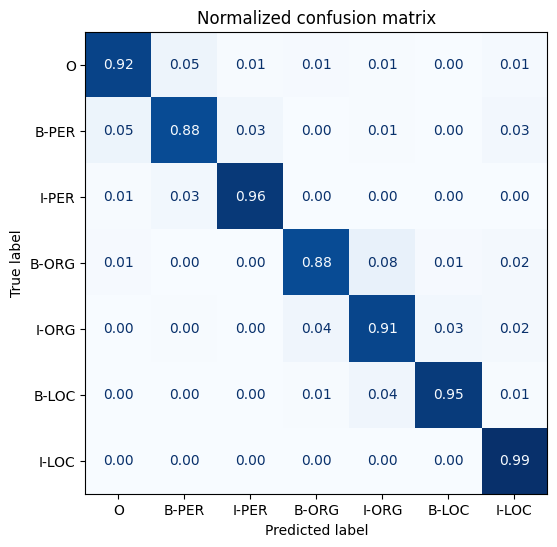

In [88]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],tags.names)